In [1]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import src.draw as plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Define

In [2]:
def metrics(data,attack_indx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    attack = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    attack[attack_indx] = 1
    pred[predict_index] = 1
    
    tp = np.sum((a == 1 and p == 1) for a, p in zip(attack, pred))
    fp = np.sum((a == 0 and p == 1) for a, p in zip(attack, pred))
    fn = np.sum((a == 1 and p == 0) for a, p in zip(attack, pred))
    tn = np.sum((a == 0 and p == 0) for a, p in zip(attack, pred))
    
    accuracy = (tp + tn) / len(attack)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy,precision,recall,f1

def rate_line_segments(line_segments,df):
    for line in line_segments:
        accuracy,precision,recall,f1 = metrics(df,attack_indx,anomaly_segment=line)
        if recall >=0.5 and precision >= 0.5:
            return line,accuracy,precision,recall,f1

In [22]:
def search_max_error(method,start,stop,df):
    '''
    Segmentation by 4 algorithms, 5 max_error
    
    Parameters
    ----------
    
    method : algorithms to segment ('Topdown','Btu','Sldw','SWAB')
    start : start range of max_error
    stop : end range of max_error
    df : a single df with 25 Product_type
    
    Returns
    -------
    
    list_maxerror : A list of 5 maxerrors
    list_detect : Include the detective of each Product_type per maxerror
    
    '''
    list_maxerror = []
    list_detect = []
    method_algorithms = {'Topdown':segment.topdownsegment,
                         'Btu':segment.bottomupsegment,
                         'Sldw': segment.slidingwindowsegment,
                         'SWAB': segment.SWABsegment}
    max_errors = np.linspace(start, stop, 5)
    
    for max_error in max_errors:
        list_p_type = np.zeros(25, dtype=int)
        for i in tqdm(range(25),desc=f'Max error: {max_error:.4f} loop'):
            try:
                ts_segments, line_segments = segment.get_ts_segments(method_algorithms[f'{method}'],list(df[i].values), fit.regression, 
                                                                     fit.sumsquared_error, max_error)
                line,accuracy,precision,recall,f1 = rate_line_segments(line_segments,df[i])
                list_p_type[i] = 1
            except:
                pass 
        if np.sum(list_p_type) != 0:
            list_maxerror.append(max_error)
            list_detect.append(list_p_type)
    if len(list_maxerror)==0:
        print(f'Cant detect')
        return 0,0
    for i in range(len(list_maxerror)):
        print(f'Max_error: {list_maxerror[i]:.3f} got {np.sum(list_detect[i])}/25 features detectable ')
    return list_maxerror,list_detect

In [52]:
def save_result(ID,method,list_maxerror,list_detect):
    old_df = pd.read_csv('exp/Max_error_per_ID')

    new_df = pd.DataFrame({'ID':ID,'Algorithms':method,'Max_error':list_maxerror,'Detect':list_detect})
    new_df = pd.concat([new_df.drop(['Detect'], axis=1), new_df['Detect'].apply(pd.Series)], axis=1)
    new_columns = [f"P_type_{i+1}" for i in range(25)]
    new_df.columns = ['ID'] + ['Algorithms'] + ['Max_error'] + new_columns
    new_df['Total'] = new_df.iloc[:,3:].sum(axis=1)
    columns_order = ['ID','Algorithms','Max_error']

    df = pd.concat([old_df,new_df],ignore_index=True)
    df = df.drop_duplicates(subset=columns_order)
    df.to_csv('exp/Max_error_per_ID',index=False)
    display(df)

In [5]:
label_df = pd.read_csv('data/labeled_anomalies.csv')
label_df['anomaly_sequences'] = label_df['anomaly_sequences'].apply(lambda x: np.array(eval(x)))

In [8]:
np.sort( label_df[label_df['spacecraft']=='SMAP']['chan_id'].unique())

array(['A-1', 'A-2', 'A-3', 'A-4', 'A-5', 'A-6', 'A-7', 'A-8', 'A-9',
       'B-1', 'D-1', 'D-11', 'D-12', 'D-13', 'D-2', 'D-3', 'D-4', 'D-5',
       'D-6', 'D-7', 'D-8', 'D-9', 'E-1', 'E-10', 'E-11', 'E-12', 'E-13',
       'E-2', 'E-3', 'E-4', 'E-5', 'E-6', 'E-7', 'E-8', 'E-9', 'F-1',
       'F-2', 'F-3', 'G-1', 'G-2', 'G-3', 'G-4', 'G-6', 'G-7', 'P-1',
       'P-2', 'P-3', 'P-4', 'P-7', 'R-1', 'S-1', 'T-1', 'T-2', 'T-3'],
      dtype=object)

## $D_1$

In [53]:
anomaly_index = label_df[label_df['chan_id']=='D-1']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

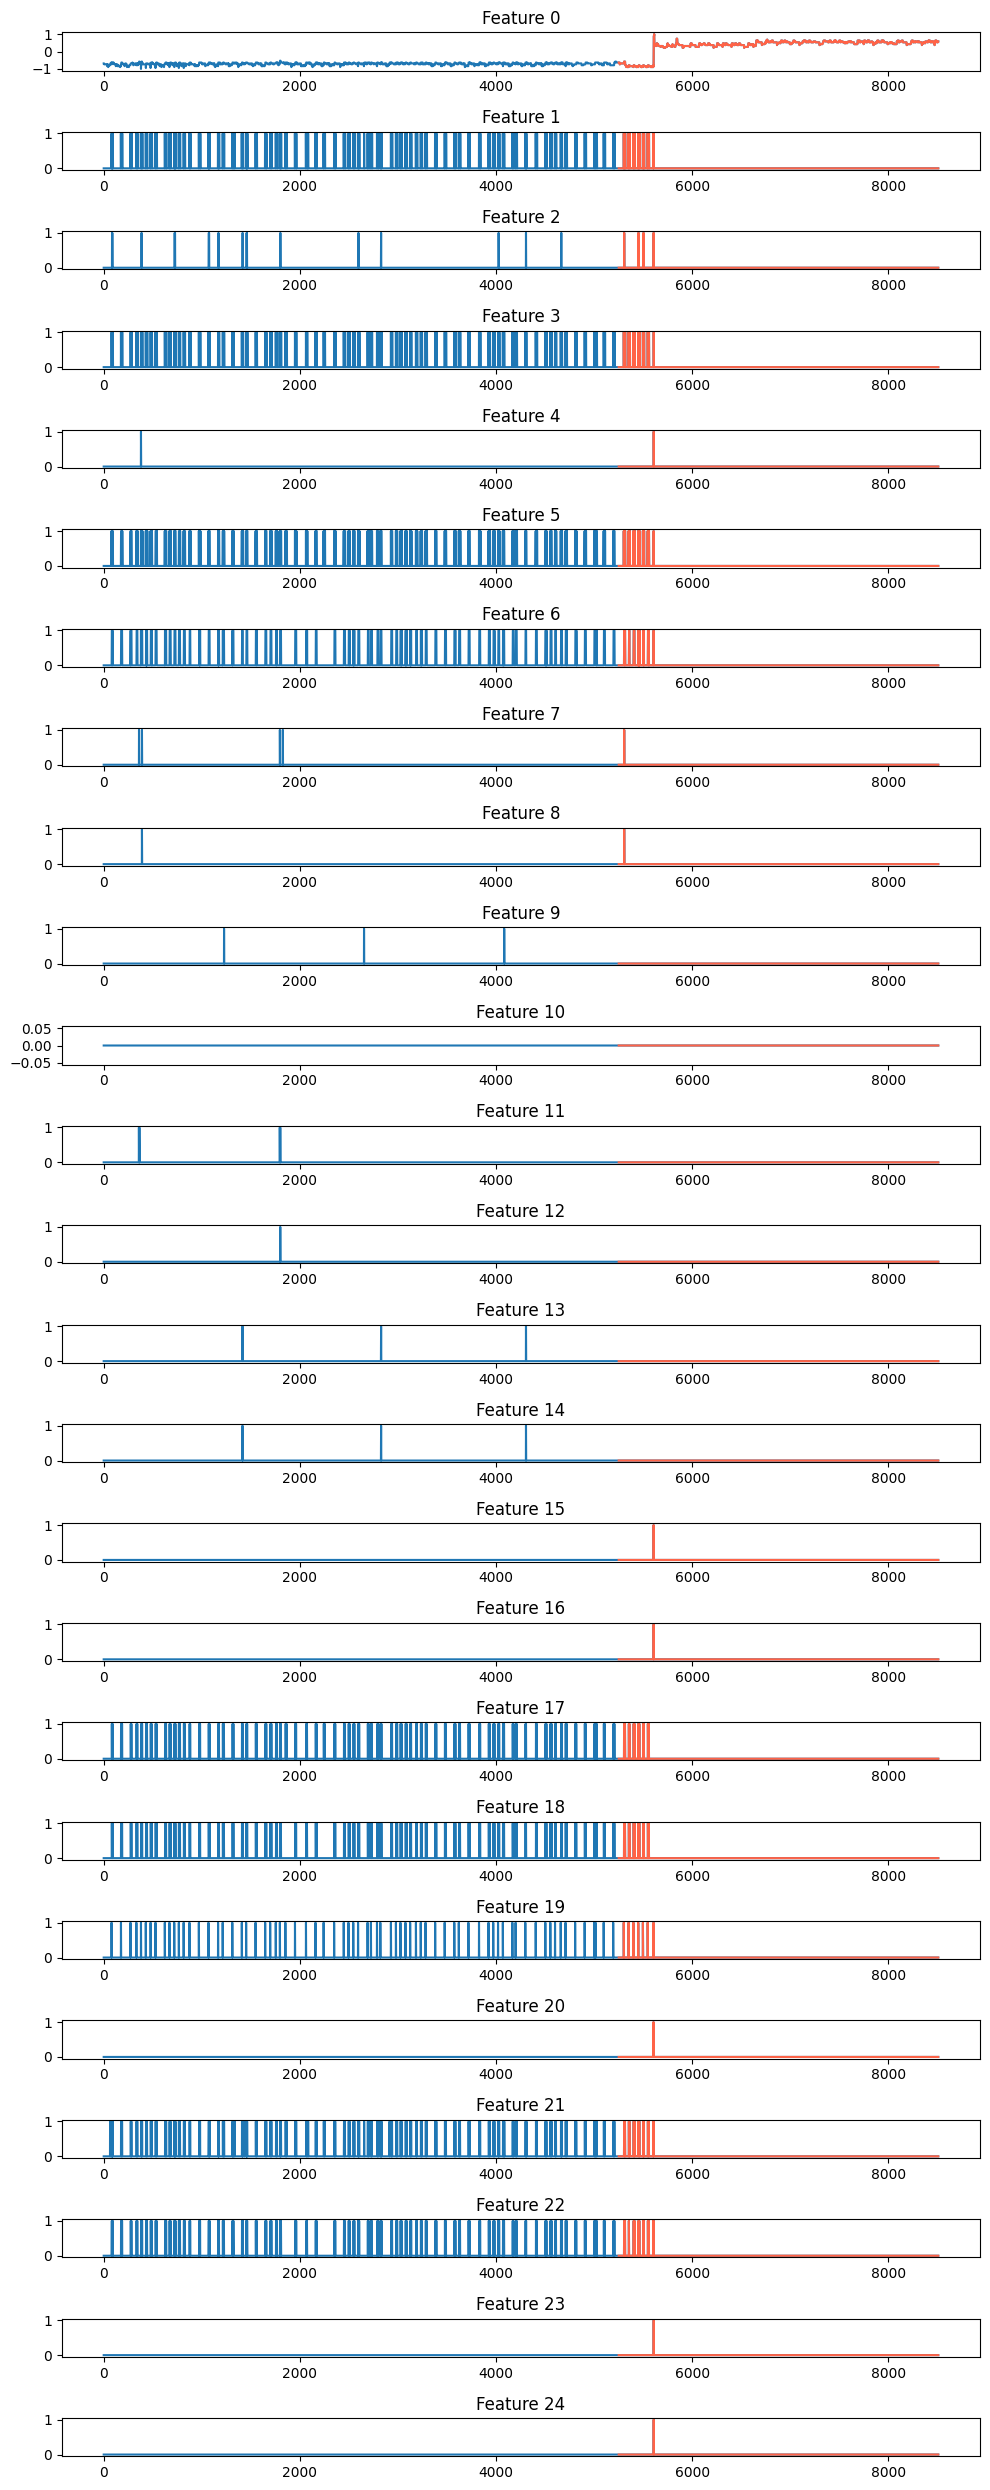

In [54]:
data = np.load('data/test/D-1.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='D-1']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

In [55]:
ID = 'D_1'

**Bottomup**

In [56]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.71s/it]

Max_error: 1.000 got 18/25 features detectable 
Max_error: 3.250 got 12/25 features detectable 
Max_error: 5.500 got 10/25 features detectable 
Max_error: 7.750 got 11/25 features detectable 
Max_error: 10.000 got 11/25 features detectable 


In [57]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
5,D_1,Bottomup,1.00,0,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,18
6,D_1,Bottomup,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
7,D_1,Bottomup,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
8,D_1,Bottomup,7.75,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
9,D_1,Bottomup,10.00,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11


**Slidingwindow**

In [58]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:28<00:00,  3.54s/it]

Max_error: 1.000 got 18/25 features detectable 
Max_error: 3.250 got 12/25 features detectable 
Max_error: 5.500 got 10/25 features detectable 
Max_error: 7.750 got 10/25 features detectable 
Max_error: 10.000 got 11/25 features detectable 


In [59]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
5,D_1,Bottomup,1.00,0,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,18
6,D_1,Bottomup,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
7,D_1,Bottomup,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
8,D_1,Bottomup,7.75,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
9,D_1,Bottomup,10.00,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11


**Topdown**

In [26]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [14:30<00:00, 34.83s/it]

Max_error: 1.000 got 18/25 features detectable 
Max_error: 3.250 got 17/25 features detectable 
Max_error: 5.500 got 17/25 features detectable 
Max_error: 7.750 got 18/25 features detectable 
Max_error: 10.000 got 18/25 features detectable 


In [27]:
save_result(ID,'Topdown',list_maxerror,list_detect)

,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,P_type_8,...,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total,ID
0,Bottomup,10.00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
1,Bottomup,13.75,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
2,Bottomup,17.50,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
3,Bottomup,21.25,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
4,Bottomup,25.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
5,Bottomup,1.00,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,9.0,NaN
6,Bottomup,3.25,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,NaN
7,Bottomup,5.50,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
8,Bottomup,7.75,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
9,Slidingwindow,1.00,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,10.0,NaN


In [67]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=0.1,stop=1,df=df)

Max error: 1.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [22:41<00:00, 54.47s/it]

Max_error: 0.100 got 2/25 features detectable 
Max_error: 0.325 got 6/25 features detectable 
Max_error: 0.550 got 5/25 features detectable 
Max_error: 0.775 got 6/25 features detectable 
Max_error: 1.000 got 4/25 features detectable 


In [66]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.000,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.250,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.500,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.750,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.000,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
5,D_1,Bottomup,1.000,0,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,18
6,D_1,Bottomup,3.250,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
7,D_1,Bottomup,5.500,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
8,D_1,Bottomup,7.750,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
9,D_1,Bottomup,10.000,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11


## D2

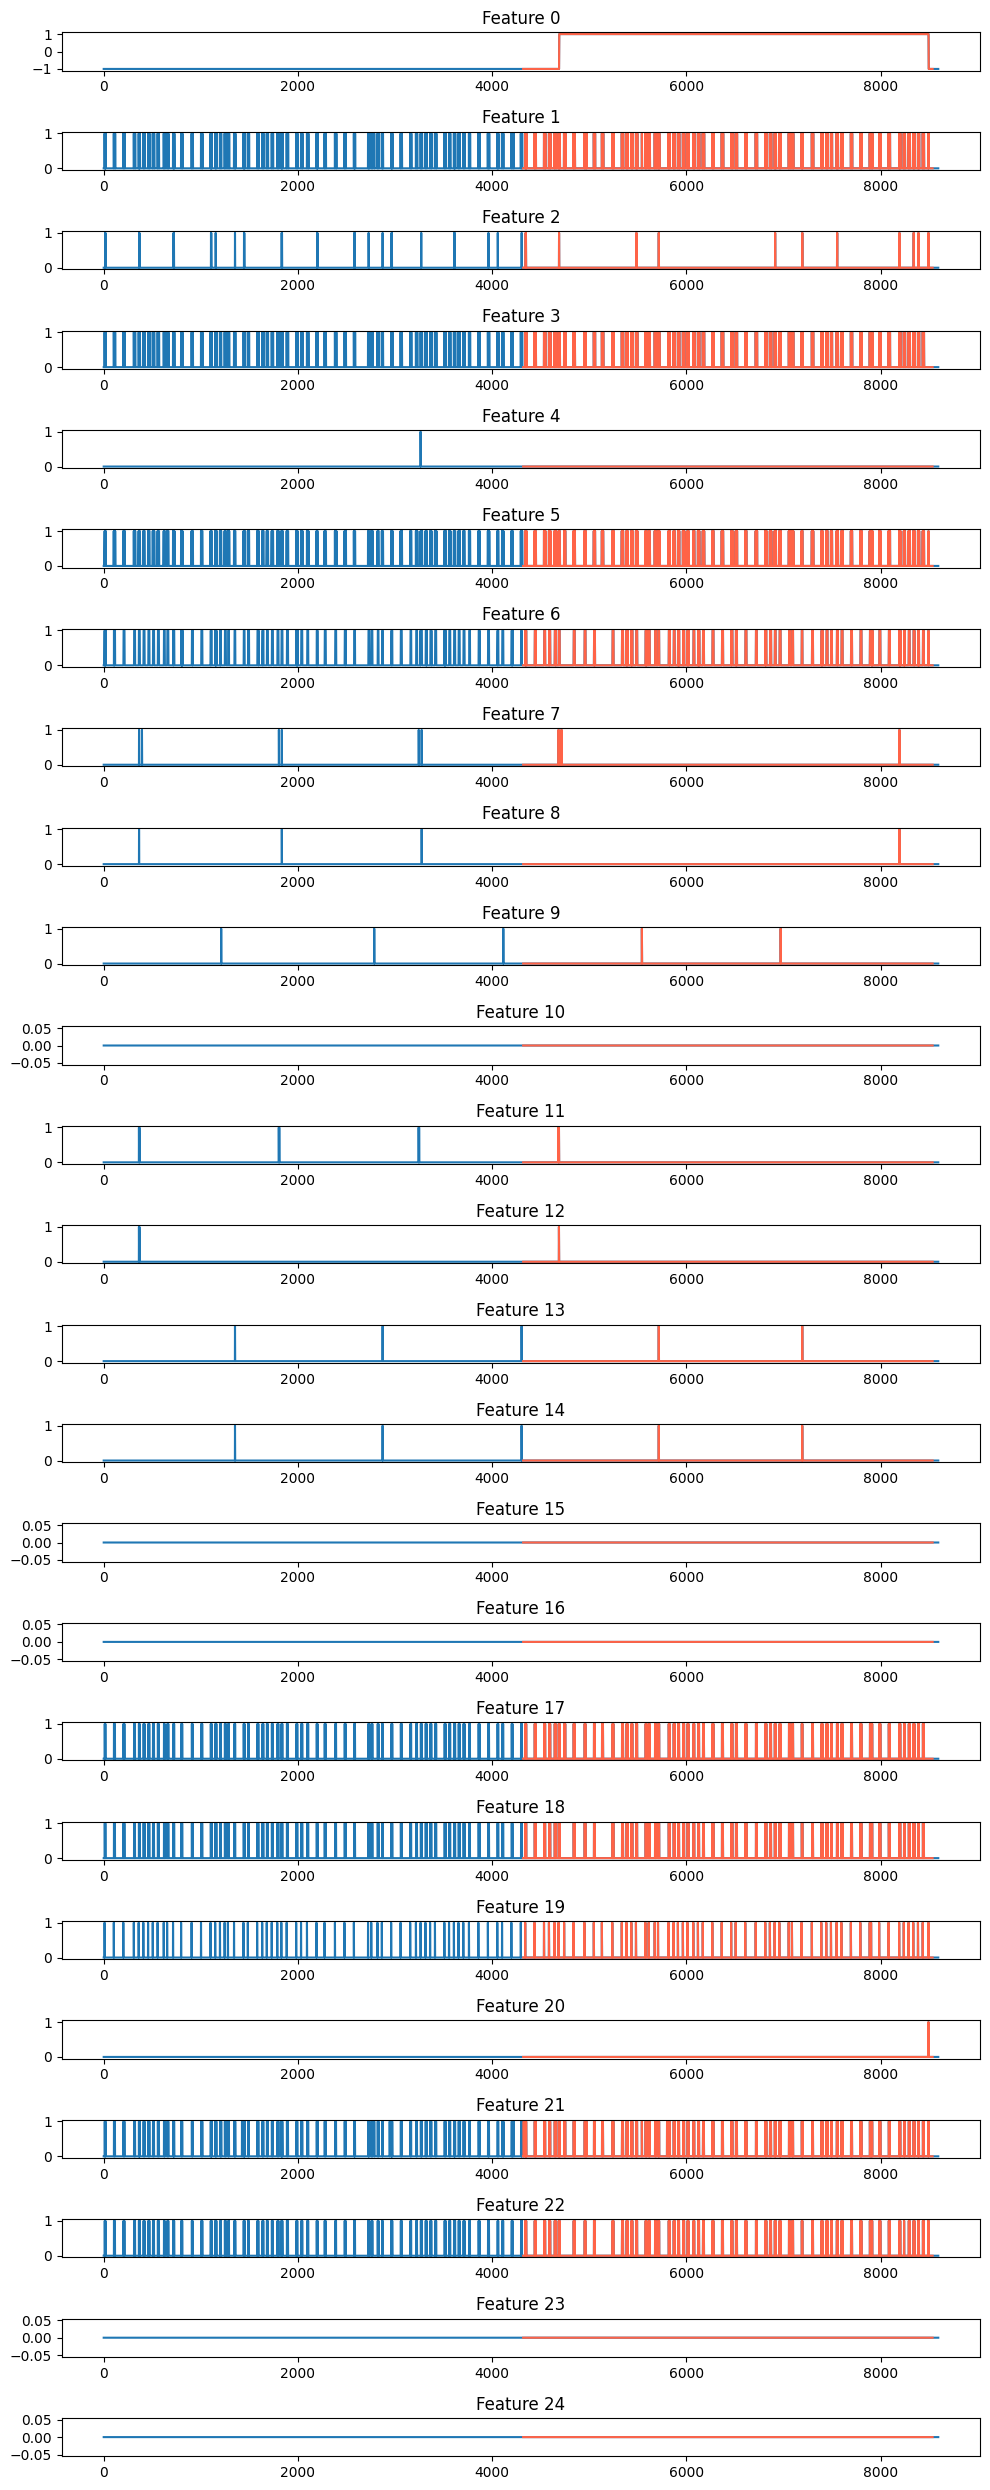

In [69]:
anomaly_index = label_df[label_df['chan_id']=='D-2']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/D-2.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='D-2']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'D_2'

In [70]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [24:33<00:00, 58.96s/it]

Max_error: 1.000 got 9/25 features detectable 
Max_error: 3.250 got 8/25 features detectable 
Max_error: 5.500 got 9/25 features detectable 
Max_error: 7.750 got 9/25 features detectable 
Max_error: 10.000 got 9/25 features detectable 


In [71]:
save_result(ID,'Topdown',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,D_2,Topdown,1.00,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9
69,D_2,Topdown,3.25,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8
70,D_2,Topdown,5.50,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9
71,D_2,Topdown,7.75,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9


In [72]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.71s/it]

Max_error: 1.000 got 6/25 features detectable 
Max_error: 3.250 got 6/25 features detectable 
Max_error: 5.500 got 6/25 features detectable 
Max_error: 7.750 got 2/25 features detectable 
Max_error: 10.000 got 2/25 features detectable 


In [73]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,D_2,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
74,D_2,Bottomup,3.25,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
75,D_2,Bottomup,5.50,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
76,D_2,Bottomup,7.75,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [80]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=0.1,stop=3,df=df)

Max error: 3.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [12:12<00:00, 29.30s/it]

Max_error: 2.275 got 2/25 features detectable 


In [81]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.000,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.250,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.500,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.750,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.000,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,A_3,Topdown,5.250,1,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,5
81,A_3,Topdown,7.625,1,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,5
82,A_3,Topdown,10.000,1,1,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,6
83,D_2,SWAB,2.550,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [86]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=0.5,stop=5,df=df)

Max error: 5.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [01:38<00:00,  3.92s/it]

Max_error: 0.500 got 6/25 features detectable 
Max_error: 1.625 got 7/25 features detectable 
Max_error: 2.750 got 6/25 features detectable 
Max_error: 3.875 got 6/25 features detectable 
Max_error: 5.000 got 5/25 features detectable 


In [87]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.000,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.250,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.500,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.750,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.000,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,D_2,Slidingwindow,0.500,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
91,D_2,Slidingwindow,1.625,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
92,D_2,Slidingwindow,2.750,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
93,D_2,Slidingwindow,3.875,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [84]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='D_1']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.000,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.250,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.500,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.750,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.000,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
5,D_1,Bottomup,1.000,0,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,18
6,D_1,Bottomup,3.250,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
7,D_1,Bottomup,5.500,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
8,D_1,Bottomup,7.750,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
9,D_1,Bottomup,10.000,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
